<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   


# HOOPS AI: CAD Access Module

## Overview

The `cadaccess` module provides a python interface for accessing and manipulating CAD models. This is empowered by HOOPS Exchange.
It defines a set of methods for loading, inspecting, and processing CAD files.

Set the license, with option validate == True. This internally test the license to confirm all is set up properly!

In [1]:
import hoops_ai
import pathlib

nb_dir = pathlib.Path.cwd()
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate=True)
#hoops_ai.set_license("my-license-key")
cad_file_with_holes = nb_dir.parent.joinpath("packages", "cadfiles","pn_verschr_r1.prt.1")

ℹ️ Using TEST LICENSE (expires February 8th, 2026 - 12 days remaining)
   For production use, obtain your own license from Tech Soft 3D
HOOPS AI version :  1.0.0-b2dev8 

✓ HOOPS AI License: Valid (TEST LICENSE)


In [2]:
from hoops_ai.insights import quick_view
viewer = quick_view(str(cad_file_with_holes))


In [3]:
viewer.show()

In [4]:
output_dir = nb_dir.joinpath("out")

# Create output directory if it does not exist
if not output_dir.exists():
    os.makedirs(output_dir)

In [5]:
viewer.terminate()

### HOOPSLoader 

The `HOOPSLoader` is the core logic for loading CAD files. For now the general options implies read feature and read solid, but this API will get richer after each version.

Key methods:
- `create_from_file(self, filename: str) -> CADModel`: Loads a CAD file and returns a HOOPSModel
- `get_model(self) -> HOOPSModel`: Returns the loaded HOOPSModel
- `set_general_options(self, options: Dict[str, Any]) -> None`: Sets options for loading CAD files
- `get_general_options(self) -> Dict[str, Any]`: Gets the current loading options

In [6]:
from hoops_ai.cadaccess import HOOPSLoader, HOOPSModel, HOOPSTools
#--------------------------------------------------------------------------------------
# CAD Loader
#--------------------------------------------------------------------------------------
loader = HOOPSLoader()
    
general_options = loader.get_general_options()
print("default parameters ->", general_options)

general_options["read_feature"] = True 
general_options["read_solid"]   = True 

loader.set_general_options(general_options)
general_options = loader.get_general_options()
print("defined parameters ->", general_options)

default parameters -> {'read_feature': False, 'read_solid': True}
defined parameters -> {'read_feature': True, 'read_solid': True}


### HOOPSModel

The `HOOPSModel` interface represents a loaded CAD model, providing access to its internal representation.

Key methods:
- `get_filesource(self) -> str`: Returns the source file path
- `get_body(self, body_index: int = 0) -> Any`: Returns the body object from the model
- `get_brep(self, body_index: int = 0) -> BrepAccess`: Returns a BrepAccess implementation for the model
- `get_mesh(self, body_index: int = 0) -> MeshAccess`: Returns a MeshAccess implementation for the model (not yet implemented)
- `get_body_count(self) -> int`: Returns the number of bodies in the model

In [7]:
model = loader.create_from_file(str(cad_file_with_holes))

In [8]:
print(model.get_body_count())

2


The `HOOPSLoader` sets the general options of how to open the CAD file. The `HOOPSModel` contains a cad file according to those specifications and now, the `HOOPSTools` will define how the Brep of this model is built.

### HOOPSTools 

The `HOOPSTools` interface provides utility methods for working with loaded CAD models:

Key methods:
- `brep_options(self) -> Dict[str, Any]`: Gets options for B-rep processing
- `adapt_brep(self, model: CADModel, brep_options: Dict[str, Any]) -> None`: Adapts the B-rep model according to provided options

- `tesselation_options(self) -> Dict[str, Any]`: Gets options for tessellation (not yet implemented)
- `adapt_tesselation(self, model: CADModel, tess_options: Dict[str, Any]) -> None`: Adapts the tessellation according to provided options (not yet implemented)

- `exportOBJ(self, model: CADModel, filepath: str) -> None`: Exports the model to OBJ format
- `exportSTEP(self, model: CADModel, filepath: str, overwrite: bool = False) -> None`: Exports the model to STEP format
- `exportStreamCache(self, model: CADModel, filepath: str, is_white_background: bool = True, overwrite: bool = False) -> None`: Exports the model to StreamCache format
- `extract_holes(self, model: CADModel) -> Dict[str, Any]`: Extracts information about holes in the model (only available for CATIA, SLW, NX, Creo files)

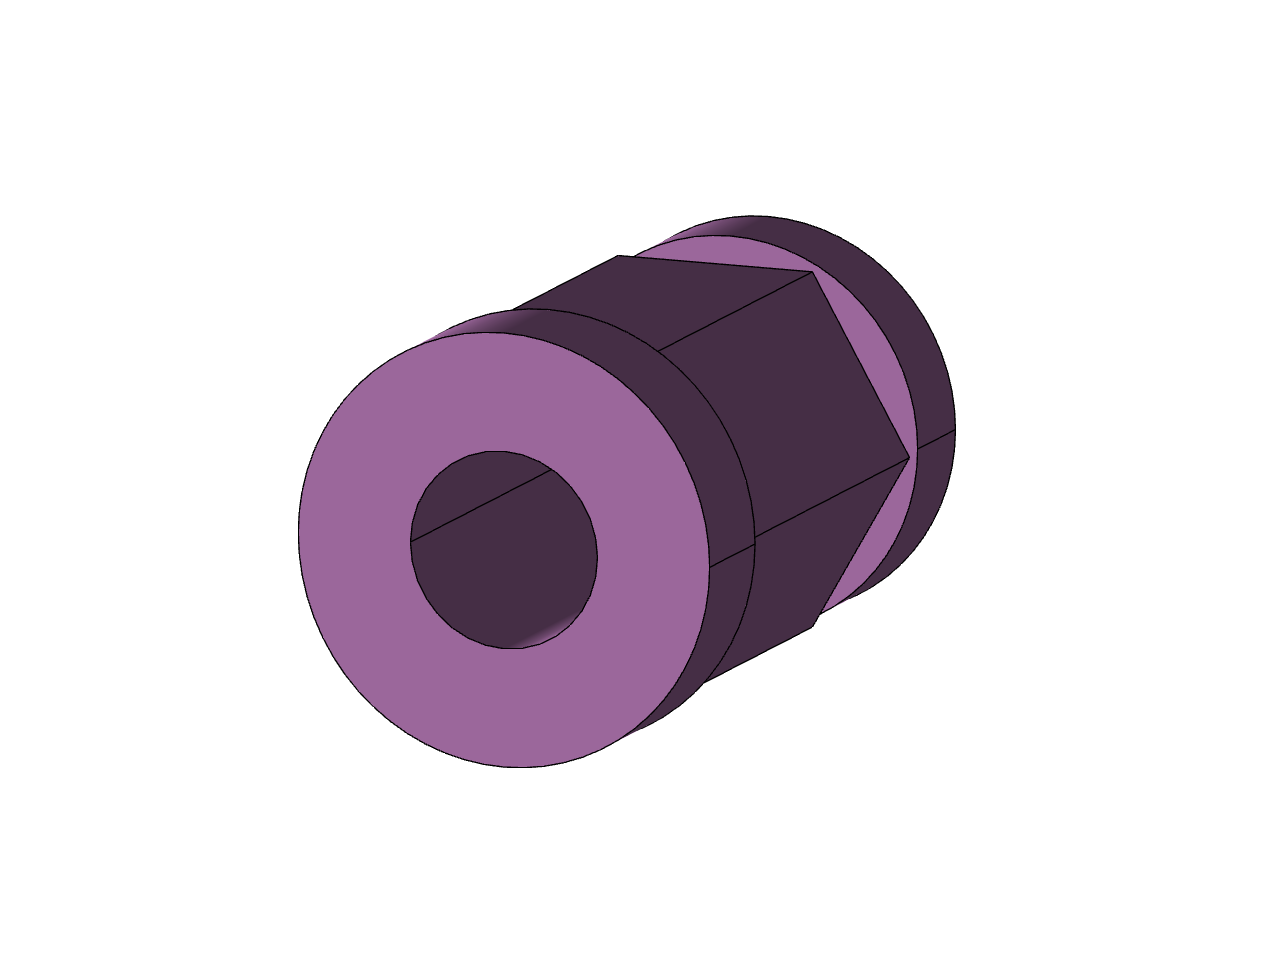

In [9]:
tools = HOOPSTools()

tools.exportStreamCache(model, str(output_dir.joinpath("exported_cad_ref1")), is_white_background=True, overwrite=True)   

# this creates a .scs file and a .mng file (check the output dir is desired)

# Display a PNG image from file
from IPython.display import Image, display
display(Image(filename=str(output_dir.joinpath("exported_cad_ref1_white.png"))))

# Holes extraction for certain Files.

The HOOPs tool have a method to extract the holes type and the Brep face list. Available only for certain files this method could be used to help at tagging for machine learning task including holes. 

IDEA: get labeled data from CAD files CATIA, SLW, NX, Creo and then use the learned model to infere in other cad files.

In [10]:
holes_data = tools.extract_holes(model)
print(holes_data)

{'hole_features': [{'face_indexes': [18, 1], 'hole_type': 'GENERAL'}]}


using the HOOPS AI Insights module, you  may reuse the stream cache file generated to visualize the cad model.

Alternatively, you could export the cad file to step or obj.

Now we will show how to visualize the brep faces belonging to the GENERAL hole feature:


![](../packages/cadfiles/hole_extracted_from_tools.png)

# Interactive 3D Visualization with HOOPS AI Insights

The `insights` module provides a simple, Pythonic interface for visualizing CAD models in Jupyter notebooks.

## Three Ways to Visualize

The insights module provides three approaches to display the visualization from simplest to most advanced:
1. **Quick View** - One-liner for instant visualization
2. **Pre-converted SCS** - Reuse previously exported StreamCache files
3. **Full Control** - Manual viewer management for advanced workflows

## Load Pre-converted SCS Files (Efficient)

If you've already exported to StreamCache format (like we did earlier with HOOPSTools), reuse it to avoid re-conversion.

In [11]:
from hoops_ai.insights import CADViewer

# Load the SCS file we exported earlier (faster - no conversion needed)
viewer2 = CADViewer(static_folder=output_dir, display_mode='sidecar')



In [12]:
stream_cache_file = str(output_dir.joinpath("exported_cad_ref1.scs"))
print(stream_cache_file)
viewer2.load_scs_file(stream_cache_file)

C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\exported_cad_ref1.scs


True

In [13]:
# Side car view doesn’t update aspect ratio when panel resized. 
# if the side car windows is too small, first resize the window to the desired size and then relaunch viewer.show()
viewer2.show()
# launch again after resizing panel

In [14]:
# Check viewer status
status = viewer2.get_status()
print(f"Viewer is running on port: {status['port']}")
print(f"Viewer URL: {status['viewer_url']}")

Viewer is running on port: 8001
Viewer URL: http://127.0.0.1:8001


In [15]:
viewer2.show()

---

## Working with the Viewer - Interactive Features

Let's use the first viewer to demonstrate interactive features. All viewers support the same API.

### 1. Highlight Specific Faces by Index

Highlight the faces that belong to the first hole feature we extracted earlier.

In [16]:
# Highlight faces belonging to the first hole feature (default color)
viewer2.set_face_color(holes_data['hole_features'][0]['face_indexes'], [255, 0, 0])

### 2. Clear Face Colors

Remove all colors to return to the default appearance.

In [17]:
# Clear all face colors
viewer2.clear_face_colors()


### 3. Get User-Selected Faces

**Interactive Step:**
1. Click on a face in the 3D viewer to highlight it
2. Use `Ctrl + Click` to highlight multiple faces
3. Run the cell below to retrieve your selection

In [18]:
# Get the face indices you selected interactively
selected_faces = viewer2.get_selected_faces()

print(f"You selected {len(selected_faces)} faces: {selected_faces}")

You selected 0 faces: []


### 4. Highlight Selected Faces with Custom Color

Color your selected faces with a custom RGB color.

In [19]:
# Highlight selected faces with a custom green color
viewer2.set_face_color(selected_faces, [150, 255, 100])

ERROR:Failed to set face color: 400 Client Error: Bad Request for url: http://127.0.0.1:8001/set_face_color
ERROR:Failed to set face color: 400 Client Error: Bad Request for url: http://127.0.0.1:8001/set_face_color


HTTPError: 400 Client Error: Bad Request for url: http://127.0.0.1:8001/set_face_color

---

## Cleanup

When done with a viewer, terminate it to free up the port and resources.

**Note:** If you used the context manager pattern (Approach 3), cleanup is automatic - no need to call `terminate()`.

In [20]:
# Terminate viewers that weren't used with context manager
viewer2.terminate()


print("All viewers terminated. Ports are now free for reuse.")

All viewers terminated. Ports are now free for reuse.


---

## Summary: Which Approach to Use?

| Approach | Best For | Pros | Cons |
|----------|----------|------|------|
| **Quick View** | Fast exploration, demos | One line, simplest | Less control |
| **Pre-converted SCS** | Repeated visualization | Fast (no conversion) | Requires SCS file |
| **Context Manager** | Production code, complex workflows | Auto-cleanup, full control | More verbose |

### Quick Reference

```python
# One-liner
from hoops_ai.insights import quick_view
viewer = quick_view("model.step")

# Reuse SCS file
from hoops_ai.insights import CADViewer
viewer = CADViewer(static_folder=output_dir)
viewer.load_scs_file("model.scs")
viewer.show()

# Context manager (recommended)
with CADViewer() as viewer:
    viewer.load_cad_file("model.step")
    viewer.show()
    # Automatic cleanup
```

### Key Methods

- `load_cad_file(path)` - Load CAD file (auto-converts to SCS)
- `load_scs_file(path)` - Load pre-converted SCS file (faster)
- `show()` - Display the viewer
- `set_face_color(indices, [r, g, b])` - Highlight faces
- `get_selected_faces()` - Get user-selected faces
- `clear_face_colors()` - Remove all colors
- `terminate()` - Clean up (not needed with context manager)